<a href="https://colab.research.google.com/github/tayfununal/Uniform-Autoencoder-with-Latent-Flow-Matching/blob/main/UAE-with-LFM/generation/swissroll_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/tayfununal/Uniform-Autoencoder-with-Latent-Flow-Matching.git

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import Tensor

from sklearn.datasets import make_swiss_roll
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import os

print(os.getcwd())

%run /content/Uniform-Autoencoder-with-Latent-Flow-Matching/models/swissroll_model.ipynb
%run /content/Uniform-Autoencoder-with-Latent-Flow-Matching/datasets/swiss_roll_dataset.ipynb

# Flow Matching Model
%run /content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/models/swissroll_flow_model.ipynb

plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [ ]:
# Hyper-Parameters & Settings

dataset_size = 10000
batch_size = 5000

In [ ]:
# Dataset
test_dataset = SwissRollDataset(mode='test', n_samples=dataset_size)

# DataLoader
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [ ]:
# Load the UAE model

path = '/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/swissroll/UAE_SwissRoll'
model = torch.load(path + '.model', weights_only=False)
model.eval()

To_Uniform(
  (encoder): Sequential(
    (0): Linear(in_features=3, out_features=400, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=400, out_features=400, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=400, out_features=400, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=400, out_features=400, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=400, out_features=400, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Linear(in_features=400, out_features=2, bias=True)
    (16): Sigmoid()
  )
  (decoder): Sequential(
    (0): L

In [ ]:
# Create the "results" folder
os.makedirs("results", exist_ok=True)

flow_name = '/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/swissroll/UAE_Latent_FM'
model_eval = torch.load(flow_name + '.model', weights_only=False)
model_eval.eval()

Flow(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=2, bias=True)
  )
)

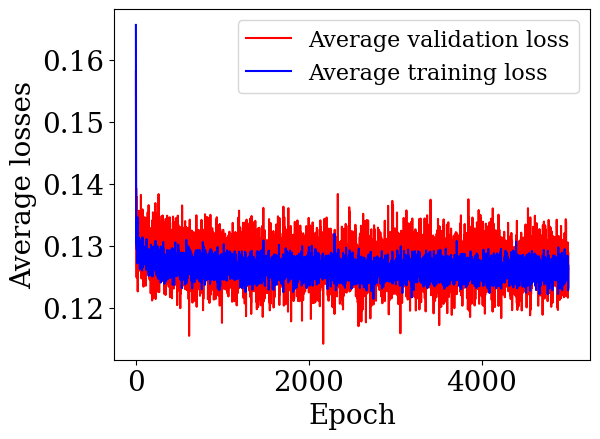

In [ ]:
# Load the losses
losses = np.loadtxt("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/swissroll/losses.csv", delimiter=",", skiprows=1)
train_losses = losses[:, 0]
val_losses = losses[:, 1]

# Create a plot
plt.plot(val_losses, label="Average validation loss", c="red")
plt.plot(train_losses, label="Average training loss", c="blue")

plt.xlabel("Epoch")
plt.ylabel("Average losses")
plt.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.savefig("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/swissroll/average_losses_per_epoch.pdf")
plt.show()

In [ ]:
x_uniform = torch.rand(test_dataset[:][0].shape[0], 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x_uniform.detach()[:, 0], x_uniform.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(0.0, 1.0)
axes[0].set_ylim(0.0, 1.0)

for i in range(n_steps):
    x_uniform = model_eval.step(x_t=x_uniform, t_start=time_steps[i], t_end=time_steps[i + 1])
    axes[i + 1].scatter(x_uniform.detach()[:, 0], x_uniform.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.savefig("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/swissroll/swissroll_FM_latent_result_along_time.pdf")
plt.show()

In [ ]:
x_1 = model.encoder(test_dataset[:][0])

# Flow Matching Results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Left plot - UAE
axs[0].scatter(x_1[:, 0].detach().numpy(), x_1[:, 1].detach().numpy(), alpha=1)
axs[0].set_xlim(0.0, 1.0)
axs[0].set_ylim(0.0, 1.0)

axs[0].set_xlabel('$z_1$')
axs[0].set_ylabel('$z_2$')

# Right plot - Flow Matching
axs[1].scatter(x_uniform[:, 0].detach().numpy(), x_uniform[:, 1].detach().numpy(), alpha=1)
axs[1].set_xlim(0.0, 1.0)
axs[1].set_ylim(0.0, 1.0)

axs[1].set_xlabel('$z_1$')
axs[1].set_ylabel('$z_2$')

plt.tight_layout()

plt.savefig("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/swissroll/FM_latent_vs_UAE_latent.pdf")
plt.show()

In [ ]:
!pip uninstall -y plotly kaleido
!pip install plotly==5.24.1 kaleido==0.2.1

In [ ]:
import plotly.express as px
import pandas as pd

new_data = model.decoder(x_uniform)

x_np = new_data.cpu().detach().numpy()

#Create a DataFrame
df = pd.DataFrame({
    'x1': x_np[:, 0],
    'x2': x_np[:, 1],
    'x3': x_np[:, 2]
})

# Plot with Plotly
fig = px.scatter_3d(df, x='x1', y='x2', z='x3', opacity=1.0)

# Assign green color
fig.update_traces(marker=dict(color='green'))

# Make axis labels subscripted
fig.update_layout(
    margin=dict(l=0, r=0, t=20, b=0),
    scene=dict(
        # Make axis values bold
        xaxis=dict(dtick=1),
        yaxis=dict(dtick=1),
        zaxis=dict(dtick=1),

        # Axis labels
        xaxis_title='x\u2081',
        yaxis_title='x\u2082',
        zaxis_title='x\u2083',

        xaxis_title_font=dict(
            size=26,
        ),
        yaxis_title_font=dict(
            size=26,
        ),
        zaxis_title_font=dict(
            size=26,
        )
    ),
    font=dict(  # Global font setting for all text
        family='Times New Roman',
        size=15,  # Global font size
    ),
    scene_camera=dict(
        eye=dict(x=0, y=2.2, z=0)  # Camera position
    ),
    legend_title_text='Sınıf',
    legend=dict(
        font=dict(size=22),  # Legend text
        title_font=dict(     # Legend title
            family='Times New Roman',
            size=22,
            color='black'
        )
    )
)
fig.update_traces(marker=dict(size=4))

fig.write_image("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/swissroll/latent_FM_uniform_to_swissroll.pdf", format="pdf")
fig.show()